In [1]:
import tabular_methods.dynamic_programming as dp
import tabular_methods.montecarlo as mc
import tabular_methods.temporal_difference as td

import utils.maze as mz
import utils.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error

# Defining the environment

Inspired by Sutton and Barton's example in the 4th chapter of its book we will solve a maze to learn how to implement tabular methods. We will implement methods such as Dynamic programming, and others that do not require full knowledge of the dynamic of the environment, namely Monte-Carlo Methods and Temporal-Difference learning. We aim to solve a maze where an agent starts from the top-row cells and its goal is to reach the green cell by maximizing the reward function, considering that when the absorbing states (i.e., the purple ones) are reached the agent gets a reward of -50, -1 when reaching a blue cell and 500 when reaching the goal cell. The action space is defined by 4 actions: up, down, right and left.

When taking an action there is a $p$ probability that the agent take that action and $1-p$ to take any other random action. Hence, the agent will need to find the best policy considering also this probabilities.

Creating the Maze:



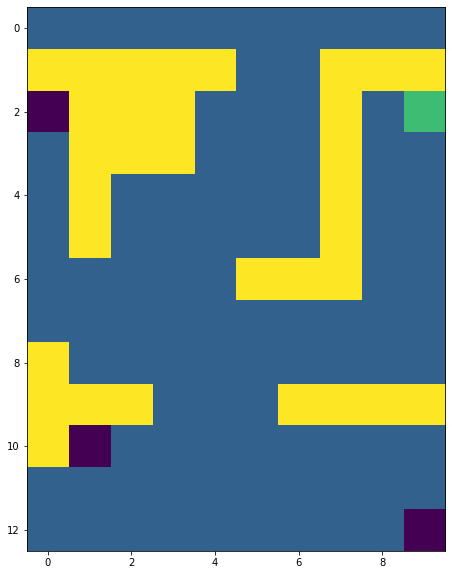

In [2]:
print("Creating the Maze:\n")
maze = mz.Maze(print=True)


# Dynamic programming

In order to apply dynamic programming in this problem we could consider using either value iteration or policy iteration. Value iteration will converge in the limit just like the policy iteration algorithm. However, value iteration avoids sweeping through the state set multiple times, and consequently converges faster. Thus, we think that it is going to be the best option in this case.

Bear in mind that value iteration is a specific version of policy iteration that converges faster, where the policy evaluation step has been truncated to just one sweep and we update the value function with the Bellman optimally equation.

- Policy iteration finds a policy as follows:

```
# Policy evaluation
while delta < small_positive_num:
    for each s in states:
        v = V[s]
        a = policy[s]
        V[s] = 0
        for each s_p in next_states:
            V[s] += P[s, a, s_p] * (R[s, a, s_p] + gamma * V[s_p])

        delta = max(delta, abs(v-V[s]))

# Policy improvement
while policy_changed:
    policy_changed = False
    for each s in states:
        initial_a = policy[s]
        max_v = -inf

        for each a in actions:
            v = 0
            for each s_p in next_states:
                v += P[s, a, s_p] * (R[s, a, s_p] + gamma * V[s_p])

            if max_v < v:
                policy[s] = a
                max_v = v

        if initial_a != policy[s]:
            policy_changed = True

```

- Value iteration iteration, on the other hand, can converge faster by updating the policy as follows:

```
while delta < small_positive_num:
    for each s in states:
        initial_v = V[s]
        
        for each a in action:
            v = 0
            for each s_p in next_state:
                v += P[s, a, s_p] * (R[s, a, s_p] + gamma * V[s_p])
            
            if V[s] < v:
                V[s] = v
                policy[s] = a
                
        delta = max(delta, abs(initial_v - v))
        

```
 *Some of these loops are actually implemented through matrix multiplicaion to improve the algorithm efficiency

Results of the DP agent:



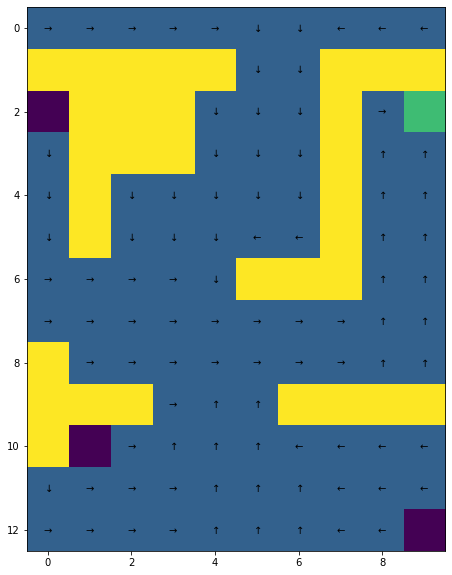

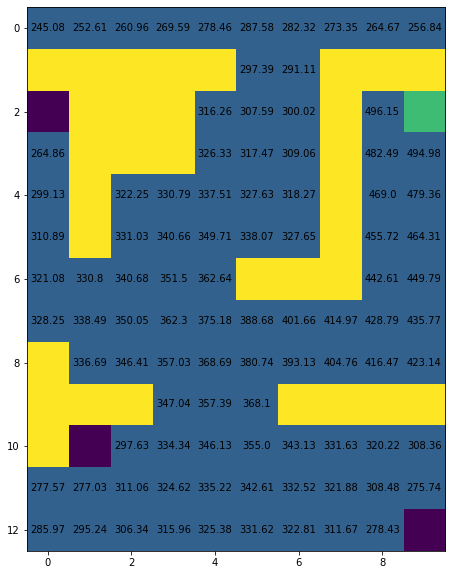

In [5]:
# Value iteration
maze_dp = mz.Maze()
dp_agent = dp.DP_agent()
dp_policy, dp_value, _ = dp_agent.solve(maze_dp)

print("Results of the DP agent:\n")
maze_dp.get_graphics().draw_policy(dp_policy, "out/dp/")
maze_dp.get_graphics().draw_value(dp_value, "out/dp/")

## Influence of $p$ on the optimal value function and policy

When it comes to the probability of success $p$, if this is lower than 0.25 (i.e. lower than random decision) the agent is going to get better results when it does not pick the optimal action than when it does. Consequently, the learned policy will be the opposite of the optimal one. Moreover, the learned values will be consistent with the learned policy, so they are not going to be optimal either:

$p = 0.1$ Optimal Policy    | $p = 0.1$ Optimal Value function
:---------------------------------:|:-------------------------:
![Optimal Policy](out/dp/policy_grid_low_p.png) | ![Optimal Value function](out/dp/value_grid_low_p.png)

It is worth noting in the next plot, that the more random is the behaviour of the agent after taking an action (maximum is when $p = 0.5$) the more epochs it takes to converge to an optimal value function and policy.

![Epochs vs p](out/dp/epochs_vs_p.png)


## Influence of $\gamma$  on the optimal value function and policy

Regarding $\gamma$, if it is low, when computing the value of a certain state, the agent is not going to consider the future rewards and hence its values will not reflect the actual return of going through that state. Taking into account that the final policy stabilises when it is optimal for the corresponding value function, if the state values are wrong, the policy will be wrong too. Note in the image below that the value function learnt when $\gamma$ is low (i.e. $\gamma = 0.05$) is wrong as almost all the values for all the states are the same and equal to -1. Therefore it is going to be difficult to find a policy that decides properly between states when the value is the same for all of them. Hence, as the value function for the states that are far from the solution will be wrong, the agent will learn a wrong policy too, specially for those states far from the solution.

$\gamma = 0.05$ Optimal Policy    | $\gamma = 0.05$ Optimal Value function
:---------------------------------:|:-------------------------:
![Optimal Policy](out/dp/policy_grid_low_gamma.png) | ![Optimal Value function](out/dp/value_grid_low_gamma.png)

In this case if $\gamma$ is lower, as the agent will be shortsighted and the future rewards will have less impact on the state values, it is going to converge faster. Note that almost all the values will be the same as the reward that the agent gets in that state, so there will barely be any difference in the value function between iterations. Hence with less $\gamma$ the agent is going to need less epochs to find the optimal value function an policy.

![Epochs vs gamma](out/dp/epochs_vs_gamma.png)

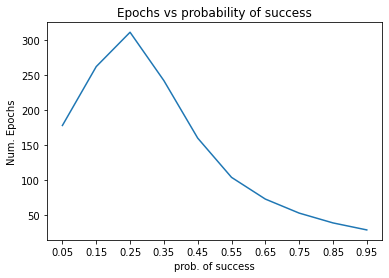

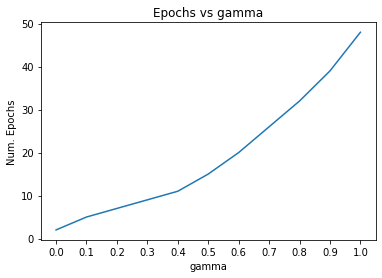

In [17]:
dp_agent = dp.DP_agent()
epochs = []
for p in np.arange(0.05, 1.05, 0.1):
    maze_dp = mz.Maze(prob_success=p)
    dp_policy, dp_value, e = dp_agent.solve(maze_dp)
    epochs.append(e)
    
plt.title("Epochs vs probability of success")
plt.plot(np.arange(0.05, 1.05, 0.1), epochs)
plt.xlabel("prob. of success")
plt.ylabel("Num. Epochs")
plt.xticks(np.arange(0.05, 1.05, 0.1))
plt.savefig("./out/dp/epochs_vs_p.png")
plt.show()

epochs = []
for g in np.arange(0.0, 1.1, 0.1):
    maze_dp = mz.Maze(gamma=g)
    dp_policy, dp_value, e = dp_agent.solve(maze_dp)
    epochs.append(e)
    
plt.title("Epochs vs gamma")
plt.plot(np.arange(0.0, 1.1, 0.1), epochs)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.xlabel("gamma")
plt.ylabel("Num. Epochs")
plt.savefig("./out/dp/epochs_vs_gamma.png")
plt.show()

# Monte-Carlo learning

To solve a control problem with a Monte-Carlo agent we could have used either an off-policy MC control algorithm or an online one (as we have done inhere). However, as Sutton and Barto claim (Sutton & Barto 2018), in the case of off-policy MC, the value function and the policy is learned from the last steps of the episodes and it could learn slower. Hence, we are going to use a on-policy Monte-Carlo algorithm.

In this case we use the first-visit version of the algorithm. Hence we bootstrap the value function as following:

```

for i in range(n_episodes):
    episode = get_episode(policy) # epsilon greedy policy
    G = 0
    for t in range(len(episode)-1, -1, -1):
        s, a, r = episode[t]
        G = r + gamma*G
        
        if (s, a) not in [(s, a) for (s, a, r) in episode[0:t]]:
            Q[s, a] = Q[s, a] + alpha * (G - Q[s, a])
        
        opt_a = argmax(Q[S, :])
        for a in actions:
            if a == opt_a:
                policy[opt_a, s] = 1 - epsilon + epsilon/len(actions)
            else:
                policy[a, s] = epsilon/len(actions)
        
```
*if we would have used the every-visit version we could avoid the ```if (s, a) not in [(s, a) for (s, a, r) in episode[0:t]]:```condition.


Solving episode 999, of length 363


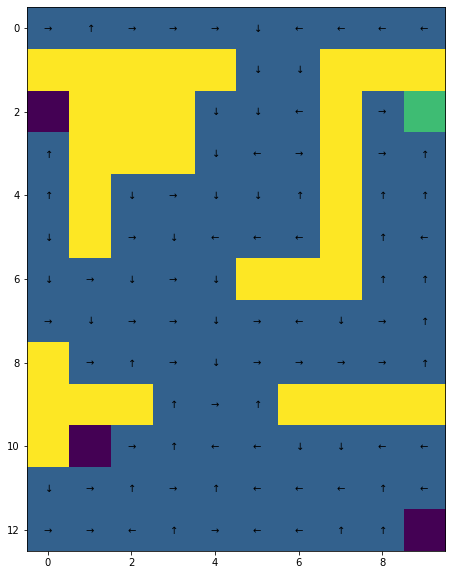

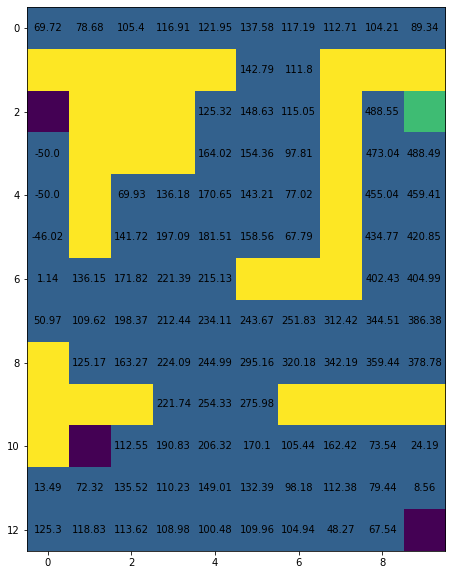

In [6]:
mc_agent = mc.MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

maze.get_graphics().draw_policy(mc_policy, "out/mc/")
maze.get_graphics().draw_value(mc_values[-1], "out/mc/")

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

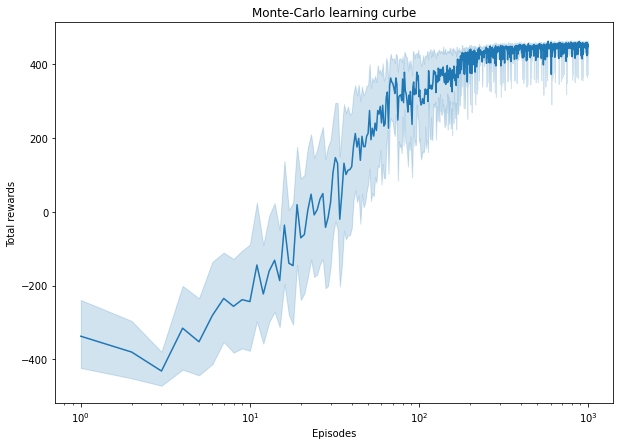

In [3]:
N_REPLICATIONS = 20
df = None
for i in tqdm(range(N_REPLICATIONS), unit="replication"):
    mc_agent = mc.MC_agent()
    mc_policy, mc_values, total_rewards = mc_agent.solve(maze, total_episodes=1000)
    df = utils.append_results(total_rewards, i, df=df)

plt.figure(figsize=(10,7))
plt.title("Monte-Carlo learning curbe")
sns.lineplot(data=df, x="Episodes", y="Total rewards")
plt.xscale('log')
plt.savefig('out/mc/learningcurve.png', dpi=150, bbox_inches='tight')
plt.show()

## Variability in the learning process

The Monte-Carlo estimation relies on many stochastic factors that cause the agent to explore different state-actions in each episode and consequently the return for a specific number of episodes is going to change if we replicate the learning process.

Among these stochastic factors, one of the most relevant, if not the most, are the randomly taken actions, and the corresponding random states, that are explored, according to the probability distribution that defines the learned policy. It is relevant to notice, that the higher the $\epsilon$ is, the more chances of picking a different action-state for different replications of the same process. Thus, for higher $\epsilon$, there will be more variability among the replications. Moreover, as we initialise the Q values randomly, if those are close to the optimal values, the algorithm will converge much faster than if the Q values are completely far from the solution.

In order to evaluate the performance of the agent, we are going to replicate the different tests many times. The number of replications will depend on the test and can be decided by looking at the standard deviation of the different results, if there is a high standard deviation more replications are needed. If the standard deviation does not decrease by increasing the number of replications, more replications are not needed. In this case, we will perform 20 replications for each state.

## Impact of $\epsilon$ on the learning process

In Monte-Carlo methods, it is crucial to ensure a sufficient exploration of all the actions. In order to converge, all the actions must be evaluated infinitely, as the optimal action for the learned values in a certain episode and step may differ from the action that is actually going to give an optimal reward globally, as the agent does not have complete knowledge of the environment. Thus, if using an $\epsilon$-greedy policy, the ε must be large enough to allow the agent to explore several actions apart from the greedy ones, which may lead to better policies.
  
As can be seen in the plots, low $\epsilon$ (i.e. $\epsilon$ = 0.01, in blue in the left plot) need much more episodes to learn a good policy compared to the larger $\epsilon$ (i.e. $\epsilon$ = 0.2 or 0.6, in orange and green respectively), as the latter are evaluating many more state-actions and can find the best policy in the prior episodes and hence converge faster. Notwithstanding large $\epsilon$ may evaluate more actions, if $\epsilon$ is too large (i.e. $\epsilon$ = 0.9, in red in figure 6), the visited actions may differ from the optimal ones more often and hence the agent will rarely find the optimal policy and will need many more episodes to converge or even fail to converge. If $\epsilon$ is too large (∼1), the requirements of GPI (Generalised Policy Iteration) are tempted to not be satisfied as we cannot ensure that the agent is going to be moved toward a greedy policy. Consequently, the method may not converge to the optimal solution.

Moreover, the need of evaluating many actions aside from the greedy one decays as the agent gains experience and hence is closer to the optimal policy. Accordingly, a good approach could be to transition from an exploration method to an exploitation one as the number of episodes increases by decaying the $\epsilon$ after each episode. Inhere we have studied the impact on the learning curves when using an inverse decay of the $\epsilon$ ($\displaystyle \epsilon = \frac{1}{n\_episodes}$), in green in the right plot) and slower decays ($\displaystyle \epsilon = \frac{1}{\sqrt{n\_episodes}}, \epsilon = \frac{1}{\sqrt[3]{n\_episodes}}$), in orange and blue respectively. As can be seen, the functions which decay more slowly present similar learning curves to reasonable static $\epsilon$ (i.e. $\epsilon$ = 0.2) and in any case, the agent converges after $\sim100$ episodes. 

  0%|          | 0/4 [00:00<?, ?epsilon/s]

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

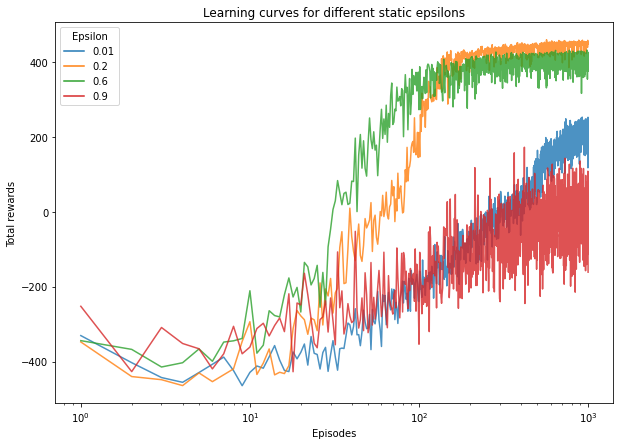

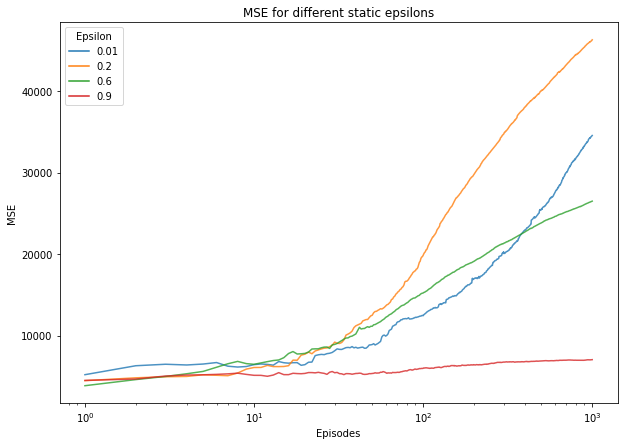

  0%|          | 0/4 [00:00<?, ?epsilon/s]

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/20 [00:00<?, ?replication/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

  0%|          | 0/1000 [00:00<?, ?episode/s]

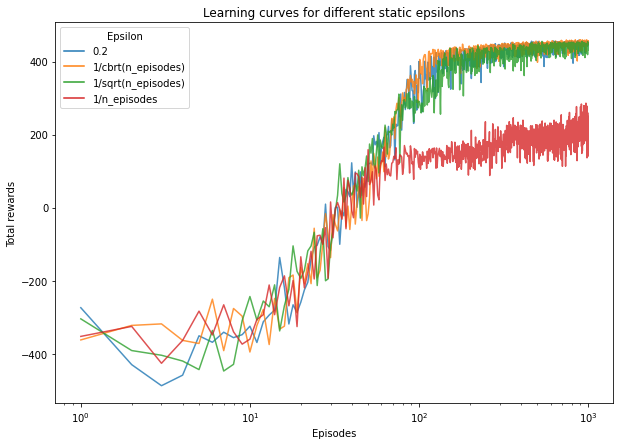

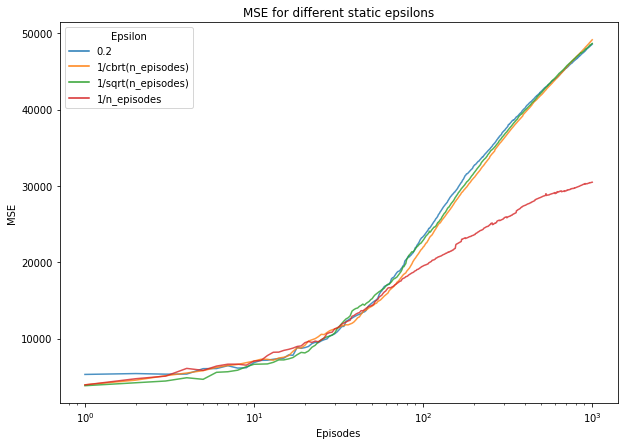

In [6]:
N_REPLICATIONS = 20
df = None
for e in tqdm([0.01, 0.2, 0.6, 0.9], unit="epsilon"):
    for i in tqdm(range(N_REPLICATIONS), leave=False, unit="replication"):
        mc_agent = mc.MC_agent()
        mc_policy, mc_values, total_rewards = mc_agent.solve(maze, epsilon=e, total_episodes=1000)

        mses = []
        for v in mc_values:
            mses.append(mean_squared_error(dp_value, v))

        df = utils.append_results(total_rewards, i, df=df, epsilon=e, mse=mses)


plt.figure(figsize=(10,7))
plt.title("Learning curves for different static epsilons")
sns.color_palette("tab10")
sns.lineplot(data=df, x="Episodes", y="Total rewards", hue='Epsilon', ci=None, palette="tab10", alpha=0.8)
plt.savefig('out/mc/learningcurve_static_eps.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,7))
plt.title("MSE for different static epsilons")
sns.color_palette("tab10")
sns.lineplot(data=df, x="Episodes", y="MSE", hue='Epsilon', ci=None, palette="tab10", alpha=0.8)
plt.savefig('out/mc/mse_static_eps.png', dpi=150, bbox_inches='tight')
plt.show()

df = None
for e in tqdm([0.2, '1/cbrt(n_episodes)', '1/sqrt(n_episodes)', '1/n_episodes'], unit="epsilon"):
    for i in tqdm(range(N_REPLICATIONS), leave=False, unit="replication"):
        mc_agent = mc.MC_agent()
        mc_policy, mc_values, total_rewards = mc_agent.solve(maze, epsilon=e, total_episodes=1000)

        mses = []
        for v in mc_values:
            mses.append(mean_squared_error(dp_value, v))

        df = utils.append_results(total_rewards, i, df=df, epsilon=e, mse=mses)


plt.figure(figsize=(10,7))
plt.title("Learning curves for different decaying epsilons")
sns.color_palette("tab10")
sns.lineplot(data=df, x="Episodes", y="Total rewards", hue='Epsilon', ci=None, palette="tab10", alpha=0.8)
plt.savefig('out/mc/learningcurve_decaying_eps.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,7))
plt.title("MSE for different decaying epsilons")
sns.color_palette("tab10")
sns.lineplot(data=df, x="Episodes", y="MSE", hue='Epsilon', ci=None, palette="tab10", alpha=0.8)
plt.savefig('out/mc/mse_decaying_eps.png', dpi=150, bbox_inches='tight')
plt.show()

# Temporal-Difference learning

In [ ]:
td_agent = td.TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

maze.get_graphics().draw_policy(td_policy, "out/td/")
maze.get_graphics().draw_value(td_values[-1], "out/td/")